# Imports
**glob**: Get files using a pattern specified by wildcard.<br>
**xarray**: Reading datafiles as multi-dimensional arrays.<br>
**numpy**: Numerical operations.<br>
**matplotlib**: Plotting data.<br>

In [32]:
from glob import glob
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
from skimage.transform import resize
import torch
import datetime

# File sorting

`*` matches 0 or more characters.

In [4]:
file_list = glob('/nvme0/gfas-frp/FRP_20??_??.nc')

A sample of file names.

In [5]:
file_list[:3]

['/nvme0/gfas-frp/FRP_2020_01.nc',
 '/nvme0/gfas-frp/FRP_2019_08.nc',
 '/nvme0/gfas-frp/FRP_2019_11.nc']

Sorting files by time to get deterministic order after loading.

In [5]:
files = sorted(file_list, key=lambda x: int(x[-8:-6])*100 + int(x[-5:-3]))

*Data is expected to be for 12 months*

In [10]:
len(files)

12

Saving the files in a separate location (once) to prevent unintended modification of original dataset. `shutil` allows efficient file operation by using shell commands under the hood.

In [20]:
# import shutil
# for file in files:
#     shutil.copy(file, '/nvme0/data_deepfwi/fwi-reanalysis')

# Preprocessing

Taking a look at data. `xarray` contains `open_dataset` function to lazy load the contents of the file.

In [12]:
xr.open_dataset(files[0])

<xarray.Dataset>
Dimensions:    (latitude: 1800, longitude: 3600, time: 30)
Coordinates:
  * longitude  (longitude) float32 0.05 0.15 0.25 0.35 ... 359.75 359.85 359.95
  * latitude   (latitude) float32 89.95 89.85 89.75 ... -89.75 -89.85 -89.95
  * time       (time) datetime64[ns] 2019-04-01 2019-04-02 ... 2019-04-30
Data variables:
    frpfire    (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2020-07-08 04:44:57 GMT by grib_to_netcdf-2.18.0: grib_to_n...

Each file contains the actual observation along with 9 day forecast.

Combining multiple files into single dataarray.

In [6]:
proc = xr.open_mfdataset(files)

/home/esowc/anaconda3/envs/wildfire-dl/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  """Entry point for launching an IPython kernel.
/home/esowc/anaconda3/envs/wildfire-dl/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


Taking a look.

In [16]:
proc

<xarray.Dataset>
Dimensions:    (latitude: 1800, longitude: 3600, time: 366)
Coordinates:
  * longitude  (longitude) float32 0.05 0.15 0.25 0.35 ... 359.75 359.85 359.95
  * latitude   (latitude) float32 89.95 89.85 89.75 ... -89.75 -89.85 -89.95
  * time       (time) datetime64[ns] 2019-04-01 2019-04-02 ... 2020-03-31
Data variables:
    frpfire    (time, latitude, longitude) float32 dask.array<chunksize=(30, 1800, 3600), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2020-07-08 04:44:57 GMT by grib_to_netcdf-2.18.0: grib_to_n...

**Pixel resolution**: *1800x3600*<br>
**Longitude resolution**: 0.10<br>
**Latitude resolution**: 0.10<br>

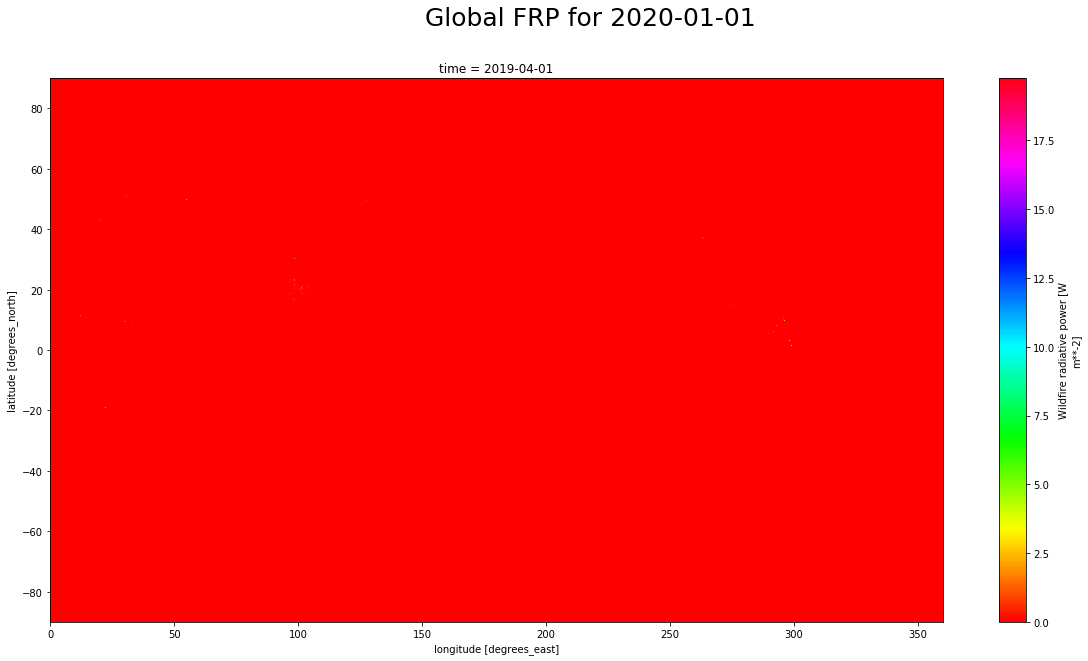

In [100]:
plt.figure(figsize = (20,10)).suptitle('Global FRP for 2020-01-01', fontsize=25)
proc.frpfire[0].plot(cmap='hsv')

Checking for NaN values.<br>
Numpy array for the `xarray` dataarray can be accessed by `values` attribute. `numpy` provides `isnan` function which returns a boolean mask. `any` method on numpy array can be used to check for atleast one instance of NaN value.

In [19]:
np.isnan(proc.frpfire[0].values).any()

False

Printing general stats.

In [107]:
def stats(x):
    tmp = x.mean()
    print('mean', tmp)
    print('mad', abs(x-tmp).mean())
    print('var', x.var())
    print('min', x.min())
    print('max', x.max())

In [24]:
stats(proc.frpfire.values)

mean 0.00021382833
mad 0.0004302753
var 0.0012904834002256393
min -7.62939453125e-06
max 186.10562133789062


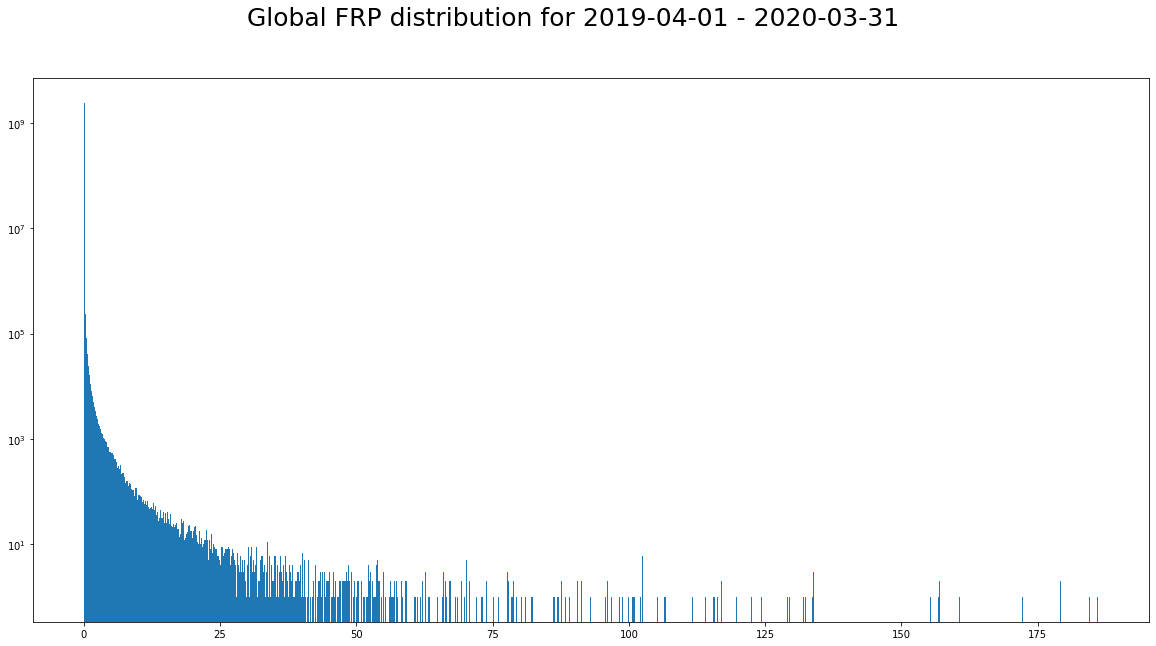

In [123]:
plt.figure(figsize = (20,10)).suptitle('Global FRP distribution for 2019-04-01 - 2020-03-31', fontsize=25)
plt.hist(proc.frpfire.values.flatten(), bins=1000, cumulative=False, log=True);

### Applying the mask for water bodies

Obtaining high resolution mask from NaN mask of fwi-forecast.

In [77]:
mask_orig = ~np.isnan(xr.open_dataset('/nvme0/fwi-forecast/ECMWF_FWI_20190130_1200_hr_fwi.nc')['fwi'][0].values)

Resizing the mask to the resolution of gfas-frp

In [87]:
mask_resized = resize(mask_orig, proc.frpfire[0].values.shape) > 0.5

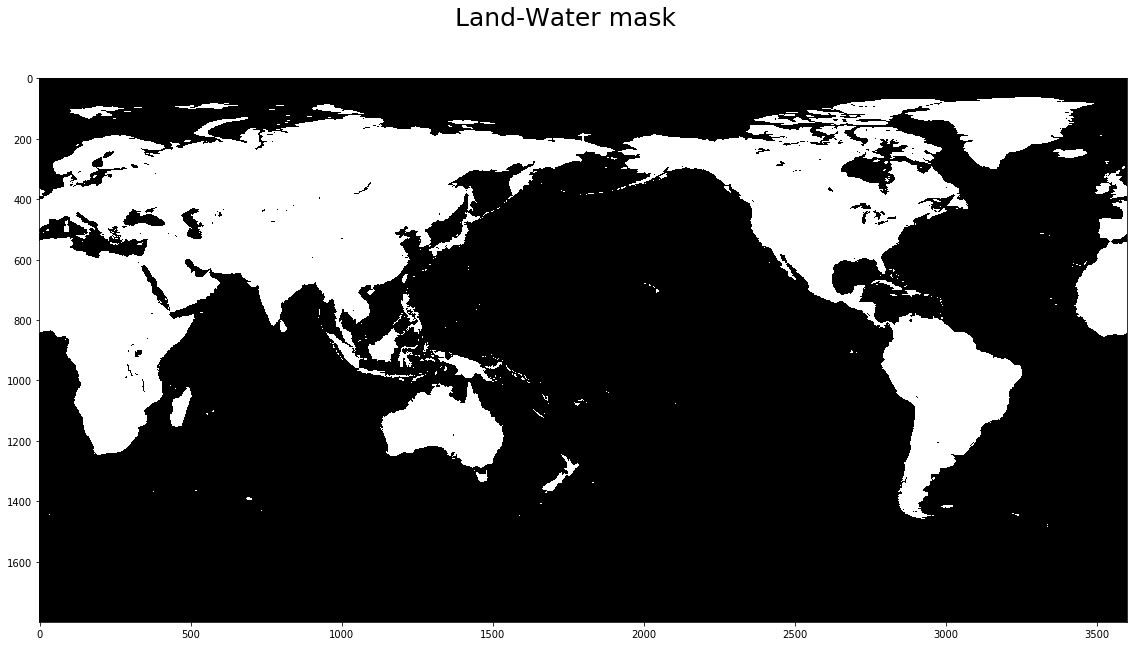

In [96]:
plt.figure(figsize = (20,10)).suptitle('Land-Water mask', fontsize=25)
plt.imshow(mask_resized, cmap='gray');

In [93]:
masked_sample = proc.frpfire[0].values.copy()
masked_sample[mask_resized] = 200

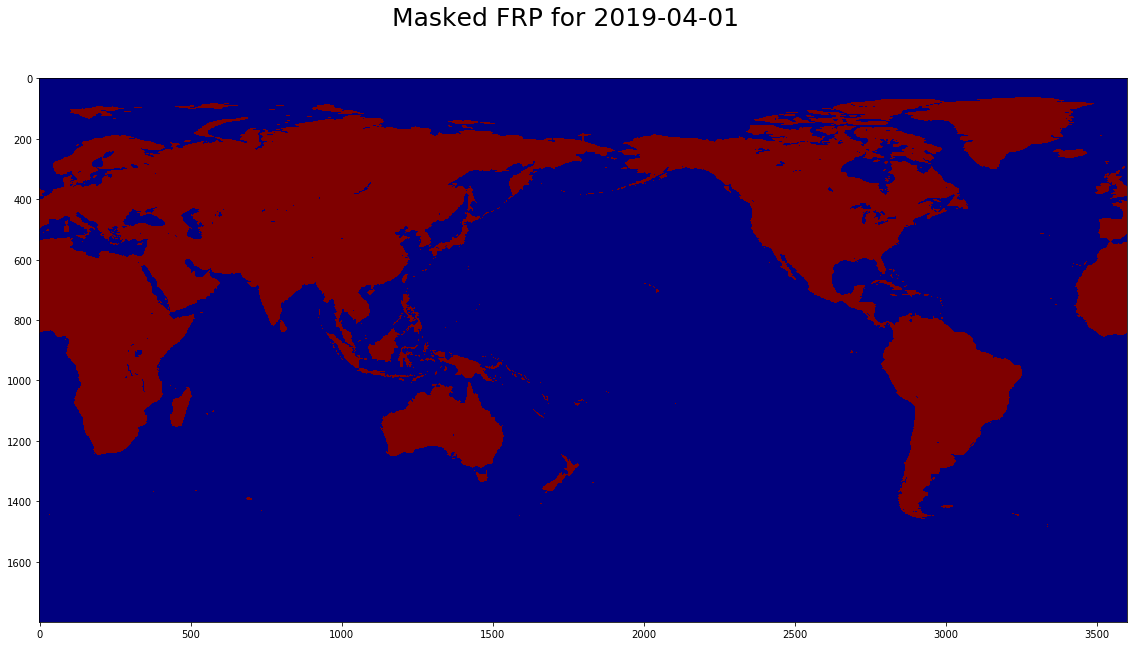

In [124]:
plt.figure(figsize = (20,10)).suptitle('Masked FRP for 2019-04-01', fontsize=25)
plt.imshow(mask_resized, cmap='jet');

In [98]:
np.save('mask_frp', mask_resized)

#### Stats for masked FRP

In [113]:
stats(proc.frpfire.values[np.broadcast_to(mask_resized, (366,)+mask_resized.shape)])

mean 0.0008449411
mad 0.0016858313
var 0.0051485044
min -7.6293945e-06
max 186.10562
